# Machine Learning


## 1. Initial Setup

- Set variables and hyperparameters
- Import libraries
- Load dataset


In [1]:
# Max allowable epochs for each model type
MAX_EPOCHS = 2000

# Hyperparameters for Hyperparameter Optimization using Optuna
OPTUNA_N_JOBS = 8  # Number of parallel jobs for hyperparameter optimization - controls how many trials run simultaneously
OPTUNA_N_TRIALS = 40  # Total number of optimization trials to run - more trials generally lead to better hyperparameter discovery
OPTUNA_PRUNE_N_STARTUP_TRIALS = 8  # Number of random trials before pruning starts - ensures diverse exploration before early stopping
OPTUNA_PRUNE_WARMUP_STEPS = 8  # Number of steps to wait before pruning can occur - prevents premature termination of promising trials


# Temp hyperparameters
# TODO: Remove these temporary hyperparameters once the final configuration is established
MAX_EPOCHS = 10
OPTUNA_N_JOBS = 2  # Number of parallel jobs for hyperparameter optimization - controls how many trials run simultaneously
OPTUNA_N_TRIALS = 2  # Total number of optimization trials to run - more trials generally lead to better hyperparameter discovery
OPTUNA_PRUNE_N_STARTUP_TRIALS = 0  # Number of random trials before pruning starts - ensures diverse exploration before early stopping
OPTUNA_PRUNE_WARMUP_STEPS = 0  # Number of steps to wait before pruning can occur - prevents premature termination of promising trials

In [2]:
PROCESSED_PATH = "../data/ANA HIDROWEB/RIO MEIA PONTE/processed.csv"

In [3]:
# Python native libraries
from typing import List, Dict, Any, Tuple
import warnings
import uuid
import random

# Data manipulation and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# PyTorch libraries and derivatives
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from torchinfo import summary

# Optuna Libraries
import optuna
from optuna.integration import PyTorchLightningPruningCallback

# Add the parent directory to the system path to import custom modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
db_path = os.path.abspath(os.path.join(os.getcwd(), "..", "db"))
if db_path not in sys.path:
    sys.path.append(db_path)

# Set precision for matrix multiplication in order to optimize performance
torch.set_float32_matmul_precision("high")

# Set random seed for reproducibility
L.seed_everything(42)

/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
Seed set to 42
Seed set to 42


42

In [4]:
from data_process import load_and_process_data_from_db

df = load_and_process_data_from_db(start_date="2014-01-01", end_date="2024-12-31")
df.index = pd.to_datetime(df.index)
df.head()

,rain_upstream_mean,rain_upstream_max,rain_upstream_min,rain_upstream_q25,rain_upstream_q75,flow_upstream_mean,flow_upstream_max,flow_upstream_min,flow_upstream_q25,flow_upstream_q75,...,level_after_q75,rain_upstream_acc_2_days,rain_downstream_acc_2_days,rain_after_acc_2_days,rain_upstream_acc_3_days,rain_downstream_acc_3_days,rain_after_acc_3_days,date_sin,date_cos,year
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,19.369072,20.1,18.3,18.8,19.8,...,291.0,0.000000,0.010309,0.0,0.000000,0.173196,0.0,0.000000,1.000000,2014
2014-01-02 00:00:00+00:00,0.004124,0.2,0.0,0.0,0.0,20.271134,21.0,19.3,19.8,20.6,...,308.0,0.004124,0.084536,0.0,0.004124,0.092784,0.0,0.017213,0.999852,2014
2014-01-03 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,20.906383,22.3,19.3,19.8,22.1,...,302.0,0.004124,0.082474,0.0,0.004124,0.084536,0.0,0.034422,0.999407,2014
2014-01-04 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,17.985567,19.8,16.7,17.4,18.3,...,280.0,0.000000,0.000000,0.0,0.004124,0.082474,0.0,0.051620,0.998667,2014
2014-01-05 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,15.802128,16.7,15.0,15.5,16.0,...,271.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.068802,0.997630,2014


## 2. Data Preprocessing

- Conferir ausência de dados nulos
- Retirar as colunas de vazão, uma vez que está altamente correlacionada à coluna de nível
- Normalização dos dados


In [5]:
# Count missing values in each column
def print_missing_values(data):
    missing_values = data.isnull().sum()
    print("Missing values in each column:")
    print(missing_values[missing_values > 0])


print_missing_values(df)

Missing values in each column:
Series([], dtype: int64)


In [6]:
# Remove columns containing 'flow' from the dataframe
df = df.loc[:, ~df.columns.str.contains("flow")]
df.head()

,rain_upstream_mean,rain_upstream_max,rain_upstream_min,rain_upstream_q25,rain_upstream_q75,level_upstream_mean,level_upstream_max,level_upstream_min,level_upstream_q25,level_upstream_q75,...,level_after_q75,rain_upstream_acc_2_days,rain_downstream_acc_2_days,rain_after_acc_2_days,rain_upstream_acc_3_days,rain_downstream_acc_3_days,rain_after_acc_3_days,date_sin,date_cos,year
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,219.154639,222.0,215.0,217.0,221.0,...,291.0,0.000000,0.010309,0.0,0.000000,0.173196,0.0,0.000000,1.000000,2014
2014-01-02 00:00:00+00:00,0.004124,0.2,0.0,0.0,0.0,222.835052,226.0,219.0,221.0,224.0,...,308.0,0.004124,0.084536,0.0,0.004124,0.092784,0.0,0.017213,0.999852,2014
2014-01-03 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,225.361702,231.0,219.0,221.0,230.0,...,302.0,0.004124,0.082474,0.0,0.004124,0.084536,0.0,0.034422,0.999407,2014
2014-01-04 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,213.515464,221.0,208.0,211.0,215.0,...,280.0,0.000000,0.000000,0.0,0.004124,0.082474,0.0,0.051620,0.998667,2014
2014-01-05 00:00:00+00:00,0.000000,0.0,0.0,0.0,0.0,204.287234,208.0,201.0,203.0,205.0,...,271.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.068802,0.997630,2014


In [7]:
scaler = StandardScaler()
# Normalize all columns except 'date_sin' and 'date_cos' (if present)
cols_to_normalize = [col for col in df.columns if col not in ["date_sin", "date_cos"]]
df_normalized = df.copy()
df_normalized[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
df_normalized.head()

,rain_upstream_mean,rain_upstream_max,rain_upstream_min,rain_upstream_q25,rain_upstream_q75,level_upstream_mean,level_upstream_max,level_upstream_min,level_upstream_q25,level_upstream_q75,...,level_after_q75,rain_upstream_acc_2_days,rain_downstream_acc_2_days,rain_after_acc_2_days,rain_upstream_acc_3_days,rain_downstream_acc_3_days,rain_after_acc_3_days,date_sin,date_cos,year
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,-0.350271,-0.347976,0.0,0.0,-0.114026,0.246097,0.072853,0.357251,0.310160,0.184338,...,0.679508,-0.452088,-0.411050,-0.35211,-0.514793,0.202644,-0.398491,0.000000,1.000000,-1.581277
2014-01-02 00:00:00+00:00,-0.309183,-0.294987,0.0,0.0,-0.114026,0.298787,0.124662,0.417361,0.368409,0.226006,...,0.854706,-0.425572,0.004581,-0.35211,-0.494664,-0.139441,-0.398491,0.017213,0.999852,-1.581277
2014-01-03 00:00:00+00:00,-0.350271,-0.347976,0.0,0.0,-0.114026,0.334959,0.189423,0.417361,0.368409,0.309341,...,0.792872,-0.425572,-0.006964,-0.35211,-0.494664,-0.174526,-0.398491,0.034422,0.999407,-1.581277
2014-01-04 00:00:00+00:00,-0.350271,-0.347976,0.0,0.0,-0.114026,0.165366,0.059901,0.252058,0.222785,0.101003,...,0.566145,-0.452088,-0.468777,-0.35211,-0.494664,-0.183298,-0.398491,0.051620,0.998667,-1.581277
2014-01-05 00:00:00+00:00,-0.350271,-0.347976,0.0,0.0,-0.114026,0.033253,-0.108478,0.146866,0.106285,-0.037890,...,0.473393,-0.452088,-0.468777,-0.35211,-0.514793,-0.534154,-0.398491,0.068802,0.997630,-1.581277


## 3. Criação dos Datasets

- Criar dataset para série temporal
- Dividir o dataset em treino, validação e teste


**A divisão dos dados**

A divisão dos dados neste projeto de séries temporais é feita em dois estágios principais:

1. **Chunking aleatório:**  
   Todo o conjunto de dados é dividido em vários "chunks" (blocos) de tamanho aleatório, variando entre 24 e 100 amostras cada. O último chunk é descartado caso tenha menos de 20 amostras, garantindo que cada bloco tenha tamanho suficiente para conter padrões temporais relevantes.

2. **Split sequencial dentro de cada chunk:**  
   Cada chunk é dividido sequencialmente em três partes: treino (60%), validação (20%) e teste (20%). Assim, cada bloco preserva a ordem temporal dos dados, e cada divisão é feita respeitando a sequência original.

---

**Por que usar chunking em séries temporais?**

- Ao dividir em chunks aleatórios, aumentamos a diversidade dos padrões apresentados ao modelo, pois cada chunk pode capturar diferentes regimes, sazonalidades ou comportamentos do sistema ao longo do tempo.
- Chunking reduz o risco de o modelo se especializar apenas em um período específico da série, promovendo maior generalização.
- Essa abordagem é especialmente útil quando há mudanças de regime, rupturas ou eventos raros distribuídos ao longo do tempo, pois aumenta a chance de tais eventos aparecerem em diferentes splits (treino, validação, teste).

---

**Comparação com divisão sequencial tradicional**

Na divisão sequencial tradicional (por exemplo, 60% inicial para treino, 20% seguinte para validação e 20% final para teste), temos:

- O modelo treina apenas com os dados do início da série, valida com dados intermediários e testa apenas com o final da série.
- Isso pode ser problemático se houver tendências, sazonalidades ou mudanças de regime ao longo do tempo, pois o modelo pode não ser exposto a todos os padrões relevantes durante o treinamento.
- Eventos raros ou extremos podem ficar concentrados em apenas um dos splits, prejudicando a avaliação do modelo.

---

**Benefícios do chunking aleatório para séries temporais**

- Diversifica os contextos temporais em cada split, tornando a avaliação mais robusta.
- Ajuda a simular cenários de produção, onde o modelo pode ser aplicado em diferentes períodos e condições.
- Mantém a ordem temporal dentro de cada chunk, respeitando a estrutura de dependência temporal essencial para séries temporais.
- Reduz o risco de overfitting a um único regime temporal.

---

_Em resumo: chunking aleatório seguido de split sequencial dentro de cada chunk é uma estratégia que preserva a ordem temporal local, aumenta a diversidade dos dados em cada etapa do treinamento e avaliação, e proporciona uma avaliação mais realista e robusta do desempenho do modelo em séries temporais._


In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length=24, target_col="level_downstream_max"):
        self.data = data.reset_index(drop=True)
        self.sequence_length = sequence_length
        self.target_col = self.data.columns.get_loc(target_col)

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data.iloc[
            idx : idx + self.sequence_length
        ].values  # (sequence_length, num_features)
        y = self.data.iloc[idx + self.sequence_length, self.target_col]  # scalar value
        return torch.tensor(x, dtype=torch.float32), torch.tensor(
            y, dtype=torch.float32
        )


class NonOverlappingConcatDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.cumulative_lengths = []
        total = 0
        for d in datasets:
            self.cumulative_lengths.append(total)
            total += len(d)
        self.total_length = total

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        # Find which dataset this idx belongs to
        for i in range(len(self.datasets)):
            if idx < self.cumulative_lengths[i] + len(self.datasets[i]):
                local_idx = idx - self.cumulative_lengths[i]
                return self.datasets[i][local_idx]
        raise IndexError("Index out of range")


def split_train_validation_test(
    data: pd.DataFrame, train_size: float = 0.6, val_size: float = 0.2
):
    train_end = int(len(data) * train_size)
    val_end = int(len(data) * (train_size + val_size))

    train_data = data.iloc[:train_end]
    val_data = data.iloc[train_end:val_end]
    test_data = data.iloc[val_end:]

    return train_data, val_data, test_data


def create_datasets(
    sequence_length: int,
    min_chunk_size: int = 24,
    max_chunk_size: int = 100,
) -> Tuple[
    NonOverlappingConcatDataset,
    NonOverlappingConcatDataset,
    NonOverlappingConcatDataset,
]:
    import random

    datasets_train: List[TimeSeriesDataset] = []
    datasets_validation: List[TimeSeriesDataset] = []
    datasets_test: List[TimeSeriesDataset] = []

    data = df_normalized.reset_index(drop=True)
    n = len(data)
    idx = 0
    chunk_indices = []

    # Generate random chunk indices
    while idx < n:
        chunk_size = random.randint(min_chunk_size, max_chunk_size)
        if idx + chunk_size >= n:
            # Last chunk
            if n - idx < min_chunk_size:
                break  # Discard last chunk if too small
            chunk_indices.append((idx, n))
            break
        else:
            chunk_indices.append((idx, idx + chunk_size))
            idx += chunk_size

    for start, end in chunk_indices:
        chunk = data.iloc[start:end].reset_index(drop=True)
        if not chunk.empty:
            train_data, validation_data, test_data = split_train_validation_test(chunk)
            if (
                len(train_data) > sequence_length
                and len(validation_data) > sequence_length
                and len(test_data) > sequence_length
            ):
                datasets_train.append(
                    TimeSeriesDataset(train_data, sequence_length=sequence_length)
                )
                datasets_validation.append(
                    TimeSeriesDataset(validation_data, sequence_length=sequence_length)
                )
                datasets_test.append(
                    TimeSeriesDataset(test_data, sequence_length=sequence_length)
                )

    train_dataset = NonOverlappingConcatDataset(datasets_train)
    validation_dataset = NonOverlappingConcatDataset(datasets_validation)
    test_dataset = NonOverlappingConcatDataset(datasets_test)

    return train_dataset, validation_dataset, test_dataset


# Debugging example
# fake_train, fake_validation, fake_test = create_datasets(
#     sequence_length=2,
# )  # Example with sequence length of 2

# print(fake_train[0][1])
# fake_train[0][0].shape, fake_train[0][1].shape  # Should be (2, num_features), scalar

In [9]:
# Test for TimeSeriesDataset

# Create a simple DataFrame with increasing integers
test_df = pd.DataFrame({"A": np.arange(10)})

# Window length = 3
ts_dataset = TimeSeriesDataset(test_df, sequence_length=3, target_col="A")

print("Testing TimeSeriesDataset:")
for i in range(len(ts_dataset)):
    x, y = ts_dataset[i]
    print(f"Index {i}: x = {x.squeeze().numpy()}, y = {y.numpy()}")

# Test for NonOverlappingConcatDataset
# Create two small TimeSeriesDatasets
df1 = pd.DataFrame({"A": np.arange(5)})
df2 = pd.DataFrame({"A": np.arange(10, 15)})

ds1 = TimeSeriesDataset(df1, sequence_length=2, target_col="A")
ds2 = TimeSeriesDataset(df2, sequence_length=2, target_col="A")

concat_ds = NonOverlappingConcatDataset([ds1, ds2])

print("\nTesting NonOverlappingConcatDataset")
print("Should not overlap and should concatenate correctly:")
for i in range(len(concat_ds)):
    x, y = concat_ds[i]
    print(f"Index {i}: x = {x.squeeze().numpy()}, y = {y.numpy()}")

Testing TimeSeriesDataset:
Index 0: x = [0. 1. 2.], y = 3.0
Index 1: x = [1. 2. 3.], y = 4.0
Index 2: x = [2. 3. 4.], y = 5.0
Index 3: x = [3. 4. 5.], y = 6.0
Index 4: x = [4. 5. 6.], y = 7.0
Index 5: x = [5. 6. 7.], y = 8.0
Index 6: x = [6. 7. 8.], y = 9.0

Testing NonOverlappingConcatDataset
Should not overlap and should concatenate correctly:
Index 0: x = [0. 1.], y = 2.0
Index 1: x = [1. 2.], y = 3.0
Index 2: x = [2. 3.], y = 4.0
Index 3: x = [10. 11.], y = 12.0
Index 4: x = [11. 12.], y = 13.0
Index 5: x = [12. 13.], y = 14.0


## 4. Definição dos Modelos


In [10]:
class MLP(L.LightningModule):
    def __init__(
        self,
        input_size,
        hidden_layers,
        learning_rate: float = 0.0001,
    ):
        super(MLP, self).__init__()
        self.save_hyperparameters()

        # MLP para cada passo temporal
        layers = []
        in_features = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            in_features = hidden_size
        self.step_mlp = nn.Sequential(*layers)
        self.final_layer = nn.Linear(in_features, 1)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        # x: (batch, window_length, input_size)
        # Aplica o MLP em cada passo temporal    print("x type:", type(x))
        batch, window, features = x.shape
        x = x.view(-1, features)  # (batch * window_length, input_size)
        out = self.step_mlp(x)  # (batch * window_length, hidden)
        out = out.view(batch, window, -1)  # (batch, window_length, hidden)
        out = out.mean(dim=1)  # (batch, hidden) - agregação temporal
        out = self.final_layer(out)  # (batch, input_size)
        return out.squeeze(-1)  # (batch,)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        return loss


class LSTM(L.LightningModule):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        learning_rate: float = 0.0001,
    ):
        super(LSTM, self).__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        out, _ = self.lstm(x)  # (batch, sequence_length, hidden_size)
        return self.fc(out[:, -1, :]).squeeze(-1)  # (batch,)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        return loss


class GRU(L.LightningModule):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        learning_rate: float = 0.0001,
    ):
        super(GRU, self).__init__()
        self.save_hyperparameters()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :]).squeeze(-1)  # (batch,)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        return loss


print(summary(MLP(input_size=5, hidden_layers=[10, 10])))
print("\n")
print(summary(LSTM(input_size=5, hidden_size=10, num_layers=2)))
print("\n")
print(summary(GRU(input_size=5, hidden_size=10, num_layers=2)))

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       60
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       110
│    └─ReLU: 2-4                         --
├─Linear: 1-2                            11
├─MSELoss: 1-3                           --
Total params: 181
Trainable params: 181
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
LSTM                                     --
├─LSTM: 1-1                              1,560
├─Linear: 1-2                            11
├─MSELoss: 1-3                           --
Total params: 1,571
Trainable params: 1,571
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
GRU                                      --
├─GRU: 1-1                               1,170
├─Linear: 1-2                            11
├─MSELoss: 1-3                           --
Total 

## 5. Treinamento dos Modelos


### 5.1. training functions


In [11]:
def train_model(
    model,
    train_data,
    val_data,
    logger,
    epochs,
    batch_size,
    callbacks=[],
    verbose=True,
) -> None:
    """
    Treina o modelo com os dados de treino e validação.
    """

    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, drop_last=True
    )
    validation_loader = DataLoader(
        val_data, batch_size=4, shuffle=False, drop_last=True
    )

    trainer = Trainer(
        max_epochs=epochs,
        accelerator="auto",
        devices=1,
        logger=logger,
        enable_progress_bar=verbose,
        log_every_n_steps=1,
        callbacks=callbacks,
        deterministic=True,
        check_val_every_n_epoch=1,
        enable_model_summary=verbose,
    )
    trainer.fit(model, train_loader, validation_loader)


def evaluate_model(model, test_data, logger, batch_size=4):
    """
    Avalia o modelo com os dados de teste.
    """
    print("\nEvaluating model. Using the test dataset.")
    test_loader = DataLoader(
        test_data, batch_size=batch_size, shuffle=False, drop_last=True
    )

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        logger=logger,
        enable_progress_bar=True,
        deterministic=True,
    )
    trainer.test(model, test_loader)


def run_experiment(
    model_class: type[L.LightningModule],
    name: str,
    model_kwargs: Dict[str, Any] = {},
    train_kwargs: Dict[str, Any] = {},
    evaluate: bool = True,
    extra_callbacks: List[L.Callback] = [],
    verbose: bool = True,
    id: str = "",
):
    """
    Executa um experimento de treinamento e avaliação do modelo.
    """
    # Logger
    logger = TensorBoardLogger(save_dir=os.getcwd(), name=f"lightning_logs/{name}")

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss", mode="min", save_top_k=1, filename=f"best_model_{id}"
    )

    early_stopping_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=10,
        mode="min",
        strict=False,
    )

    train_dataset, validation_dataset, test_dataset = create_datasets(
        sequence_length=train_kwargs.get("sequence_length", 5)
    )

    # Remove 'sequence_length' from train_kwargs if present
    train_kwargs = dict(train_kwargs)  # make a copy to avoid side effects
    train_kwargs.pop("sequence_length", None)

    input_size = train_dataset[0][0].shape[1]  # Assuming all inputs have the same shape

    model = model_class(input_size=input_size, **(model_kwargs or {}))

    train_model(
        model,
        train_dataset,
        validation_dataset,
        logger=logger,
        **(train_kwargs or {}),
        callbacks=[checkpoint_callback, early_stopping_callback, *extra_callbacks],
        verbose=verbose,
    )

    best_validation_loss = checkpoint_callback.best_model_score
    best_model_path = checkpoint_callback.best_model_path

    # To view the logs, you can use TensorBoard.
    # If 'logs' is a SummaryWriter, get its log_dir and launch TensorBoard:
    print(f"To view logs, run in terminal:\n  tensorboard --logdir {logger.log_dir}")
    print("Best model saved at:", best_model_path)

    if evaluate:
        best_model = model_class.load_from_checkpoint(best_model_path, **model_kwargs)
        evaluate_model(best_model, test_dataset, logger, batch_size=4)

    return {
        "best_validation_loss": (
            best_validation_loss.item() if best_validation_loss is not None else None
        ),
        "best_model_path": best_model_path,
    }

### 5.2. Hyperparameter optimization functions


In [12]:
def get_optimization_args(model_class: L.LightningModule, trial):
    """
    Retorna os argumentos necessários para executar o experimento.
    """
    if model_class == MLP:
        model_kwargs = {
            "hidden_layers": trial.suggest_categorical(
                "hidden_layers",
                (
                    [32, 16],
                    [48, 24],
                    [64, 32],
                    [96, 48],
                    [128, 64],
                    [64, 32, 16],
                    [128, 64, 32],
                ),
            ),
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
        }
        train_kwargs = {
            "epochs": MAX_EPOCHS,
            "batch_size": trial.suggest_int("batch_size", 2, 32),
            "sequence_length": trial.suggest_int("sequence_length", 2, 15),
        }
    elif model_class == LSTM:
        model_kwargs = {
            "hidden_size": trial.suggest_int("hidden_size", 16, 128),
            "num_layers": trial.suggest_int("num_layers", 1, 3),
            "learning_rate": trial.suggest_float("learning_rate", 1e-7, 1e-3, log=True),
        }
        train_kwargs = {
            "epochs": MAX_EPOCHS,
            "batch_size": trial.suggest_int("batch_size", 2, 32),
            "sequence_length": trial.suggest_int("sequence_length", 2, 15),
        }
    elif model_class == GRU:
        model_kwargs = {
            "hidden_size": trial.suggest_int("hidden_size", 16, 128),
            "num_layers": trial.suggest_int("num_layers", 1, 3),
            "learning_rate": trial.suggest_float("learning_rate", 1e-7, 1e-3, log=True),
        }
        train_kwargs = {
            "epochs": MAX_EPOCHS,
            "batch_size": trial.suggest_int("batch_size", 8, 32),
            "sequence_length": trial.suggest_int("sequence_length", 3, 12),
        }
    else:
        raise ValueError(f"Unsupported model class: {model_class}")
    return model_kwargs, train_kwargs


def get_objective_fn(model_class, name):
    """
    Retorna uma função de objetivo para otimização de hiperparâmetros.
    """

    def objective(trial: optuna.trial.Trial) -> float:
        # Ajusta os hiperparâmetros com base no trial
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            model_kwargs, train_kwargs = get_optimization_args(model_class, trial)

        optuna_pruning_callback = PyTorchLightningPruningCallback(
            trial, monitor="val_loss"
        )

        results = run_experiment(
            model_class=model_class,
            name=name,
            model_kwargs=model_kwargs,
            train_kwargs=train_kwargs,
            evaluate=False,
            extra_callbacks=[optuna_pruning_callback],
            verbose=False,
            id=uuid.uuid4().hex[:8],
        )
        return results["best_validation_loss"]

    return objective


def run_optimization(objective_fn, n_trials=OPTUNA_N_TRIALS) -> optuna.study.Study:
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=OPTUNA_PRUNE_N_STARTUP_TRIALS,
        n_warmup_steps=OPTUNA_PRUNE_WARMUP_STEPS,
    )
    study = optuna.create_study(direction="minimize", pruner=pruner)
    study.optimize(
        objective_fn, n_trials=n_trials, n_jobs=OPTUNA_N_JOBS, show_progress_bar=True
    )

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return study

### 5.3. Training loop


In [13]:
mlp_objective_fn = get_objective_fn(
    MLP,
    "mlp",
)

study_mlp = run_optimization(mlp_objective_fn, n_trials=OPTUNA_N_TRIALS)

mlp_optimized_results = run_experiment(
    MLP,
    "mlp_optimized",
    model_kwargs={
        "hidden_layers": study_mlp.best_trial.params["hidden_layers"],
        "learning_rate": study_mlp.best_trial.params["learning_rate"],
    },
    train_kwargs={
        "epochs": MAX_EPOCHS,
        "batch_size": study_mlp.best_trial.params["batch_size"],
        "sequence_length": study_mlp.best_trial.params["sequence_length"],
    },
    evaluate=True,
    verbose=True,
)

print("\nMLP Optimized Results:", mlp_optimized_results)

[I 2025-06-06 14:36:02,262] A new study created in memory with name: no-name-3bbbe1f1-f2b6-4ab1-847d-0a56fb85451d


  0%|          | 0/2 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
2025-06-06 14:36:02.915584: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-06 14:36:02.952346: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-06 14:36:03.129380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instruc

To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_3
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp/version_3/checkpoints/best_model_ad1b8f6d.ckpt
[I 2025-06-06 14:36:12,190] Trial 0 finished with value: 0.23310083150863647 and parameters: {'hidden_layers': [128, 64, 32], 'learning_rate': 2.6152655231561496e-05, 'batch_size': 14, 'sequence_length': 11}. Best is trial 0 with value: 0.23310083150863647.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | step_mlp    | Sequential | 15.5 K | train
1 | final_layer | Linear     | 33     | train
2 | criterion   | MSELoss    | 0      | train
---------------------------------------------------
15.5 K    Trainable params
0         Non-trainable params
15.5 K    Total params
0.062     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | step_mlp    | Sequential | 15.5 K | train
1 | final_layer | Linear     | 33     | train
2 | criterion   | MSELoss    | 0      | train
----

[I 2025-06-06 14:36:12,631] Trial 1 pruned. Trial was pruned at epoch 8.
Best trial:
  Value: 0.23310083150863647
  Params: 
    hidden_layers: [128, 64, 32]
    learning_rate: 2.6152655231561496e-05
    batch_size: 14
    sequence_length: 11


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp_optimized/version_2
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp_optimized/version_2/checkpoints/best_model_.ckpt


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating model. Using the test dataset.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6962277889251709     │
└───────────────────────────┴───────────────────────────┘


MLP Optimized Results: {'best_validation_loss': 0.47584789991378784, 'best_model_path': '/home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/mlp_optimized/version_2/checkpoints/best_model_.ckpt'}


In [14]:
lstm_objective_fn = get_objective_fn(
    LSTM,
    "lstm",
)
study_lstm = run_optimization(lstm_objective_fn, n_trials=OPTUNA_N_TRIALS)
lstm_optimized_results = run_experiment(
    LSTM,
    "lstm_optimized",
    model_kwargs={
        "hidden_size": study_lstm.best_trial.params["hidden_size"],
        "num_layers": study_lstm.best_trial.params["num_layers"],
        "learning_rate": study_lstm.best_trial.params["learning_rate"],
    },
    train_kwargs={
        "epochs": MAX_EPOCHS,
        "batch_size": study_lstm.best_trial.params["batch_size"],
    },
    evaluate=True,
    verbose=True,
)
print("\nLSTM Optimized Results:", lstm_optimized_results)

[I 2025-06-06 14:36:20,519] A new study created in memory with name: no-name-68ca8aed-46b0-49f3-8e16-875f22adf5e2


  0%|          | 0/2 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.
`Trainer.fit` stopped: `max_epochs=10` reached.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_11
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm/version_11/checkpoints/best_model_941c6e5b.ckpt
[I 2025-06-06 14:36:26,793] Trial 1 finished with value: 0.2830108404159546 and parameters: {'hidden_size': 113, 'num_layers': 2, 'learning_rate': 0.00020781052587338578, 'batch_size': 24, 'sequence_length': 7}. Best is trial 1 with value: 0.2830108404159546.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 172 K  | train
1 | fc        | Linear  | 114    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
172 K     Trainable params
0         Non-trainable params
172 K     Total params
0.691     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 172 K  | train
1 | fc        | Linear  | 114    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
172 K     Tr

[I 2025-06-06 14:36:27,024] Trial 0 pruned. Trial was pruned at epoch 5.
Best trial:
  Value: 0.2830108404159546
  Params: 
    hidden_size: 113
    num_layers: 2
    learning_rate: 0.00020781052587338578
    batch_size: 24
    sequence_length: 7


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm_optimized/version_2
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm_optimized/version_2/checkpoints/best_model_.ckpt

Evaluating model. Using the test dataset.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.29845404624938965    │
└───────────────────────────┴───────────────────────────┘


LSTM Optimized Results: {'best_validation_loss': 0.33359816670417786, 'best_model_path': '/home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/lstm_optimized/version_2/checkpoints/best_model_.ckpt'}


In [15]:
gru_objective_fn = get_objective_fn(
    GRU,
    "gru",
)
study_gru = run_optimization(gru_objective_fn, n_trials=OPTUNA_N_TRIALS)
gru_optimized_results = run_experiment(
    GRU,
    "gru_optimized",
    model_kwargs={
        "hidden_size": study_gru.best_trial.params["hidden_size"],
        "num_layers": study_gru.best_trial.params["num_layers"],
        "learning_rate": study_gru.best_trial.params["learning_rate"],
    },
    train_kwargs={
        "epochs": MAX_EPOCHS,
        "batch_size": study_gru.best_trial.params["batch_size"],
    },
    evaluate=True,
    verbose=True,
)
print("\nGRU Optimized Results:", gru_optimized_results)

[I 2025-06-06 14:36:37,626] A new study created in memory with name: no-name-b13fe8b3-186d-4c61-ad63-30c7f773e8e2


  0%|          | 0/2 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.
`Trainer.fit` stopped: `max_epochs=10` reached.


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_5
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_5/checkpoints/best_model_a4f3e0ea.ckpt
[I 2025-06-06 14:36:43,472] Trial 1 finished with value: 0.7533525824546814 and parameters: {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 8.189254155239357e-07, 'batch_size': 23, 'sequence_length': 9}. Best is trial 1 with value: 0.7533525824546814.


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | gru       | GRU     | 5.0 K  | train
1 | fc        | Linear  | 26     | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | gru       | GRU     | 5.0 K  | train
1 | fc        | Linear  | 26     | train
2 | criterion

To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_6
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru/version_6/checkpoints/best_model_16ebf131.ckpt
[I 2025-06-06 14:36:44,932] Trial 0 finished with value: 0.40150415897369385 and parameters: {'hidden_size': 25, 'num_layers': 1, 'learning_rate': 0.00019063539206685002, 'batch_size': 13, 'sequence_length': 9}. Best is trial 0 with value: 0.40150415897369385.
Best trial:
  Value: 0.40150415897369385
  Params: 
    hidden_size: 25
    num_layers: 1
    learning_rate: 0.00019063539206685002
    batch_size: 13
    sequence_length: 9


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


To view logs, run in terminal:
  tensorboard --logdir /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru_optimized/version_1
Best model saved at: /home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru_optimized/version_1/checkpoints/best_model_.ckpt

Evaluating model. Using the test dataset.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4070694148540497     │
└───────────────────────────┴───────────────────────────┘


GRU Optimized Results: {'best_validation_loss': 0.4299167990684509, 'best_model_path': '/home/bruno/Workspace/FIAP/2025/gs-disaster/ml/lightning_logs/gru_optimized/version_1/checkpoints/best_model_.ckpt'}


## 6. Avaliação dos Modelos


### 6.1. Visualização

O trecho destacado gera gráficos que permitem comparar visualmente as previsões dos modelos MLP, LSTM e GRU com os valores reais de uma série temporal. O principal objetivo é facilitar a análise do desempenho dos modelos ao longo do tempo, destacando onde cada tipo de dado (treino, validação, teste) está localizado.

Cada gráfico mostra um segmento da série temporal, facilitando a visualização de séries longas. O fundo dos gráficos é colorido de acordo com o tipo de split: roxo para treino, rosa para validação e verde para teste. Isso permite identificar rapidamente em que região cada modelo foi treinado, validado ou testado.

As linhas representam:

Preto: valores reais suavizados (média móvel)
Azul, laranja e verde: previsões suavizadas dos modelos MLP, LSTM e GRU, respectivamente
Os marcadores indicam os pontos previstos e reais. Os gráficos são divididos em vários painéis (splits) para facilitar a navegação visual e evitar sobrecarga de informações em um único gráfico.

Com essa visualização, é possível perceber padrões, tendências, possíveis overfits e diferenças de desempenho dos modelos em cada região da série temporal, além de avaliar se o modelo generaliza bem para dados não vistos (validação e teste).

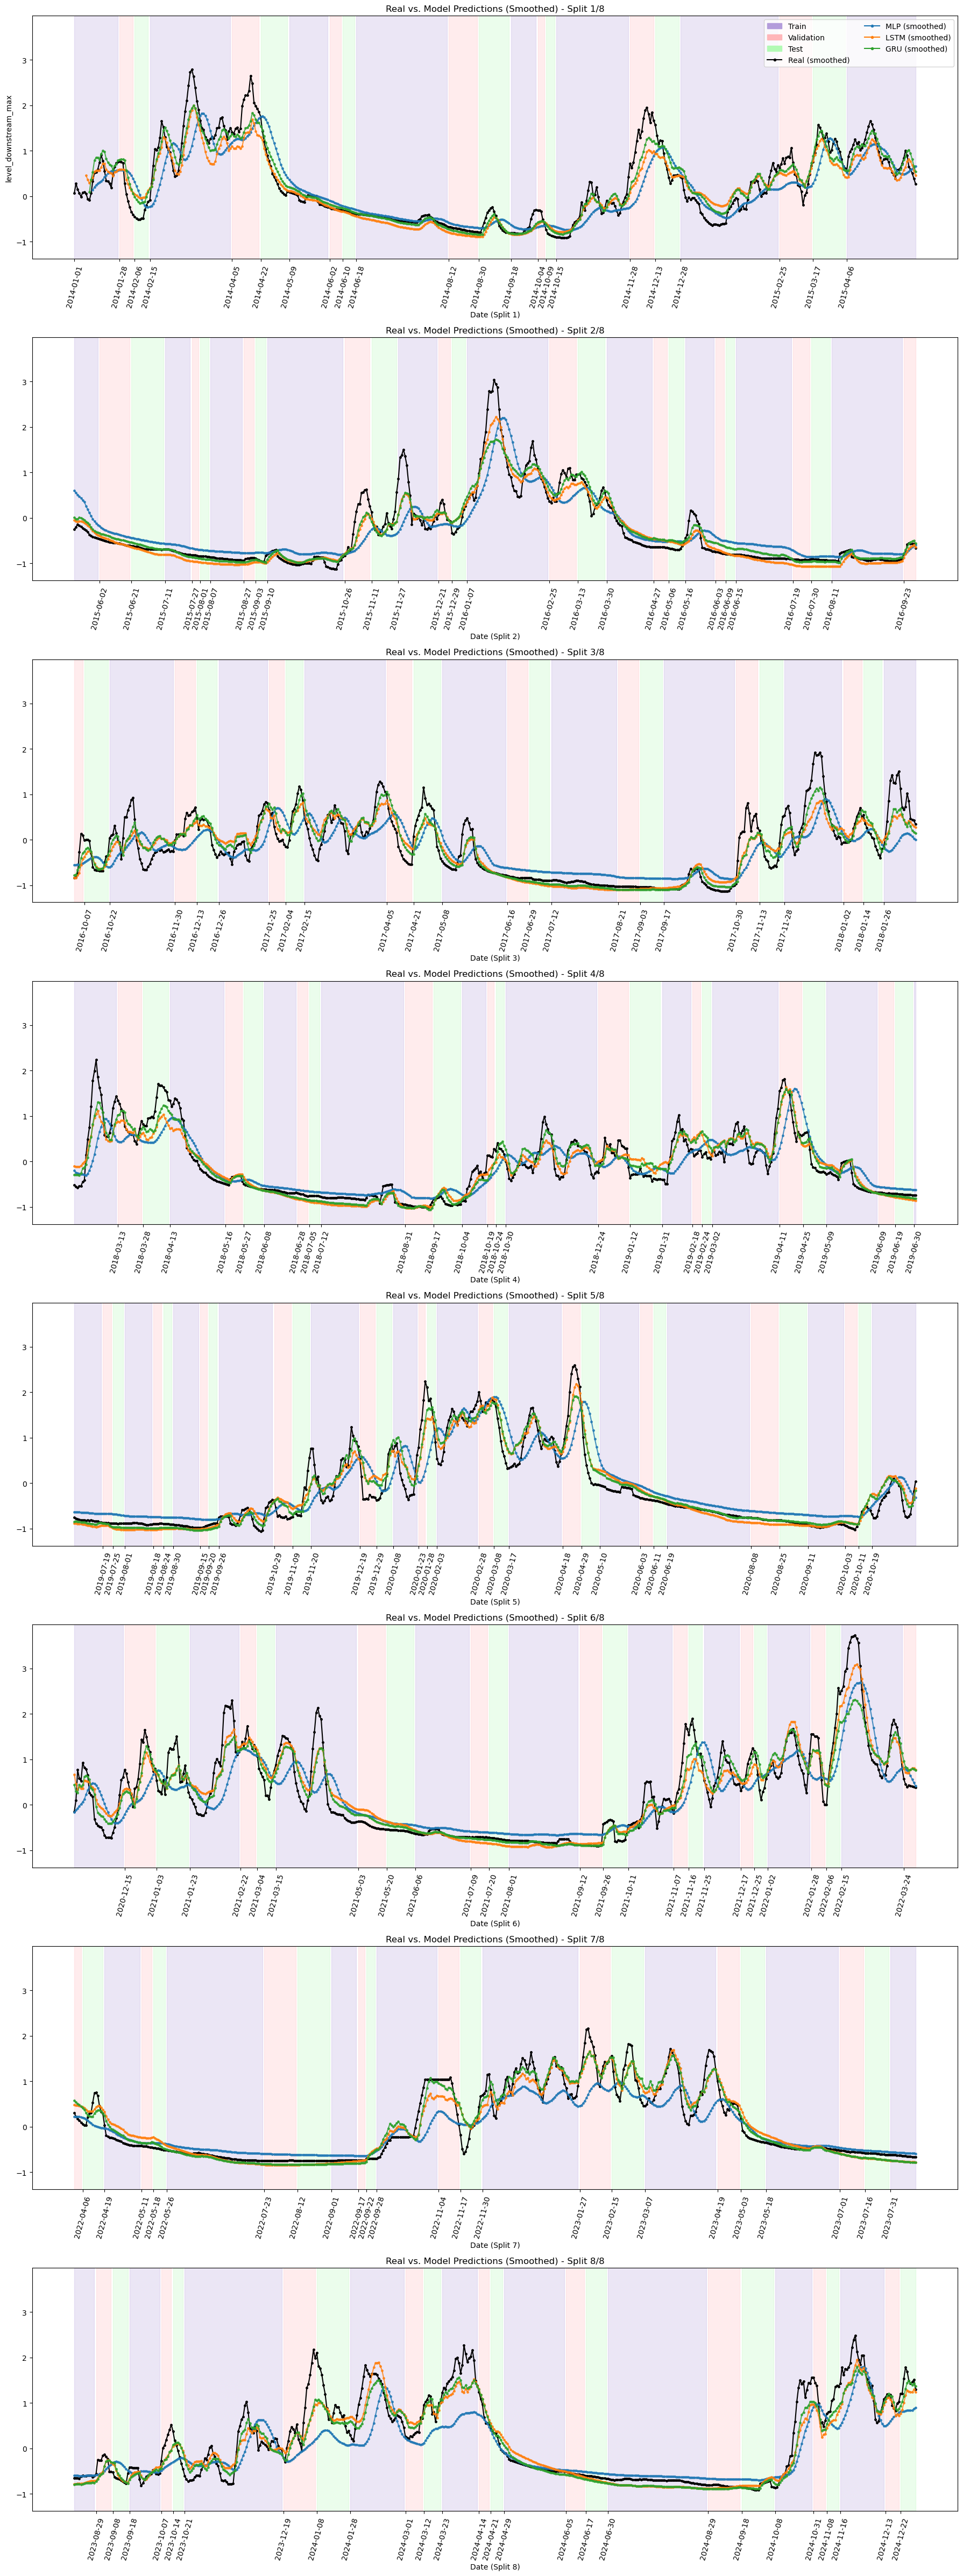

In [16]:
# --- 1. Define split colors and model colors ---
split_colors = {
    "train": "#b39ddb",  # stronger purple
    "validation": "#ffb6b9",  # stronger pink
    "test": "#b2fab4",  # stronger green
}
model_colors = {
    "Real": "black",
    "MLP": "tab:blue",
    "LSTM": "tab:orange",
    "GRU": "tab:green",
}


# --- 2. Recreate chunking and split mapping ---
def get_chunk_splits(data, sequence_length=5, min_chunk_size=24, max_chunk_size=100):
    n = len(data)
    idx = 0
    chunk_indices = []
    while idx < n:
        chunk_size = random.randint(min_chunk_size, max_chunk_size)
        if idx + chunk_size >= n:
            if n - idx < min_chunk_size:
                break
            chunk_indices.append((idx, n))
            break
        else:
            chunk_indices.append((idx, idx + chunk_size))
            idx += chunk_size

    split_map = {}
    chunk_boundaries = []
    chunk_labels = []
    for chunk_id, (start, end) in enumerate(chunk_indices):
        chunk_len = end - start
        train_end = start + int(chunk_len * 0.6)
        val_end = start + int(chunk_len * 0.8)
        # Assign split type for each index in chunk
        for i in range(start, train_end):
            split_map[i] = ("train", chunk_id)
        for i in range(train_end, val_end):
            split_map[i] = ("validation", chunk_id)
        for i in range(val_end, end):
            split_map[i] = ("test", chunk_id)
        chunk_boundaries.append((start, end))
        chunk_labels.append(f"Chunk {chunk_id}")
    return split_map, chunk_boundaries, chunk_labels


split_map, chunk_boundaries, chunk_labels = get_chunk_splits(
    df_normalized, sequence_length=5
)

# --- 3. Prepare data for plotting ---
x_labels = df_normalized.index  # Use date or index
target_col = "level_downstream_max"
real_values = df_normalized[target_col].values

# For each sample, get split type and chunk id
split_types = []
chunk_ids = []
for i in range(len(df_normalized)):
    split, chunk_id = split_map.get(i, ("none", -1))
    split_types.append(split)
    chunk_ids.append(chunk_id)


# --- 4. Prediction function for a model ---
def get_model_predictions(model, data, sequence_length=5):
    model.eval()
    preds = [None] * len(data)
    with torch.no_grad():
        for i in range(len(data) - sequence_length):
            x = data.iloc[i : i + sequence_length].values
            x_tensor = (
                torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
            )  # (1, seq, features)
            y_pred = model(x_tensor).cpu().numpy().squeeze()
            preds[i + sequence_length] = y_pred
    return preds


# Set the paths for the best models
mlp_checkpoint_path = mlp_optimized_results["best_model_path"]
lstm_checkpoint_path = lstm_optimized_results["best_model_path"]
gru_checkpoint_path = gru_optimized_results["best_model_path"]

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load best models (replace with your checkpoint paths)
mlp_model = MLP.load_from_checkpoint(mlp_checkpoint_path).to(device)
lstm_model = LSTM.load_from_checkpoint(lstm_checkpoint_path).to(device)
gru_model = GRU.load_from_checkpoint(gru_checkpoint_path).to(device)

mlp_preds = get_model_predictions(
    mlp_model,
    df_normalized,
    sequence_length=study_mlp.best_trial.params["sequence_length"],
)
lstm_preds = get_model_predictions(
    lstm_model,
    df_normalized,
    sequence_length=study_lstm.best_trial.params["sequence_length"],
)
gru_preds = get_model_predictions(
    gru_model,
    df_normalized,
    sequence_length=study_gru.best_trial.params["sequence_length"],
)

# --- 5. Plotting with smoothing (split into 4 rows) ---
n_splits = 8
n_samples = len(real_values)
split_size = n_samples // n_splits

fig, axes = plt.subplots(
    nrows=n_splits, ncols=1, figsize=(18, 6 * n_splits), sharey=True
)

window = 7  # Smoothing window size (days/samples)

for split_idx in range(n_splits):
    ax = axes[split_idx]
    start_idx = split_idx * split_size
    end_idx = (split_idx + 1) * split_size if split_idx < n_splits - 1 else n_samples

    # Get the date indices for this split
    split_dates = x_labels[start_idx:end_idx]

    # For each sample in this split, shade background according to split type
    last_split = None
    region_start = 0
    for i in range(start_idx, end_idx):
        split = split_types[i]
        if split != last_split or i == end_idx - 1:
            if last_split is not None:
                region_end = i if split != last_split else i + 1
                color = split_colors.get(last_split, "#f0f0f0")
                # Use date indices for axvspan
                ax.axvspan(
                    split_dates[region_start - start_idx],
                    (
                        split_dates[region_end - start_idx - 1]
                        if region_end - start_idx - 1 < len(split_dates)
                        else split_dates[-1]
                    ),
                    color=color,
                    alpha=0.25,
                    zorder=0,
                )
            region_start = i
            last_split = split

    # Smooth real values for this split
    real_smooth = (
        pd.Series(real_values[start_idx:end_idx], index=split_dates)
        .rolling(window, min_periods=1)
        .mean()
    )
    ax.plot(
        split_dates,
        real_smooth,
        label="Real (smoothed)" if split_idx == 0 else None,
        color=model_colors["Real"],
        marker=".",
        markersize=5,
        linewidth=1.5,
        zorder=2,
    )

    # Plot smoothed model predictions (skip None values)
    for name, preds, color in [
        ("MLP", mlp_preds, model_colors["MLP"]),
        ("LSTM", lstm_preds, model_colors["LSTM"]),
        ("GRU", gru_preds, model_colors["GRU"]),
    ]:
        idxs = [i for i in range(start_idx, end_idx) if preds[i] is not None]
        vals = [preds[i] for i in idxs]
        if vals:
            idx_dates = [x_labels[i] for i in idxs]
            vals_smooth = (
                pd.Series(vals, index=idx_dates).rolling(window, min_periods=1).mean()
            )
            ax.plot(
                idx_dates,
                vals_smooth,
                label=f"{name} (smoothed)" if split_idx == 0 else None,
                color=color,
                marker=".",
                markersize=5,
                linewidth=1.5,
                alpha=0.8,
                zorder=3,
            )
    # X-axis ticks at chunk starts within this split (now using dates)
    split_tick_indices = []
    split_tick_labels = []
    for chunk_start, chunk_end in chunk_boundaries:
        # Only consider chunks that overlap with this split
        if chunk_end <= start_idx or chunk_start >= end_idx:
            continue
        chunk_len = chunk_end - chunk_start
        train_start = chunk_start
        val_start = chunk_start + int(chunk_len * 0.6)
        test_start = chunk_start + int(chunk_len * 0.8)
        for idx in [train_start, val_start, test_start]:
            if start_idx <= idx < end_idx:
                split_tick_indices.append(idx)
                split_tick_labels.append(str(x_labels[idx].date()))

    ax.set_xticks([x_labels[i] for i in split_tick_indices])
    ax.set_xticklabels(split_tick_labels, rotation=75)
    ax.set_xlabel(f"Date (Split {split_idx+1})")
    if split_idx == 0:
        ax.set_ylabel(target_col)
    ax.set_title(
        f"Real vs. Model Predictions (Smoothed) - Split {split_idx+1}/{n_splits}"
    )

# Legends for splits (background) and models (lines) only on the first subplot
split_patches = [
    mpatches.Patch(color=split_colors[k], label=k.capitalize()) for k in split_colors
]
model_lines = [
    plt.Line2D([0], [0], color=model_colors[k], marker=".", label=f"{k} (smoothed)")
    for k in model_colors
]
axes[0].legend(handles=split_patches + model_lines, loc="upper right", ncol=2)

plt.tight_layout()
plt.show()

## 7. Conclusões